
# Embedding Dimension & Lyapunov Exponent (AMI + Cao + Wolf) — Notebook

This notebook provides an end-to-end pipeline to:
1. Compute the **time delay** \( \tau \) via **Average Mutual Information (AMI)** (with a 1/e autocorrelation fallback).
2. Estimate the **embedding dimension** \( m \) using **Cao's E1/E2** plateau rule.
3. **Reconstruct** the phase space using delay coordinates.
4. Optionally estimate the **largest Lyapunov exponent** \( \lambda_1 \) via a compact **Wolf method** implementation.
5. Plot the AMI curve and Cao's E1/E2 curves.

> **How to use:** Set `DATA_CSV` to your file (single column or the column name set in `DATA_COLUMN`). If left as `None`, the notebook will generate a simple synthetic series for demonstration.


In [1]:

import numpy as np
import pandas as pd
import warnings
from typing import Optional, Tuple
from scipy.spatial.distance import pdist, squareform, cdist
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [2]:

def _binn(x: np.ndarray, b: int) -> np.ndarray:
    '''Return bin indices in 1..b for data x.'''
    x = np.asarray(x).ravel()
    xmin, xmax = np.min(x), np.max(x)
    if xmax == xmin:
        return np.ones_like(x, dtype=int)
    xb = b * (x - xmin) / (xmax - xmin)
    bi = np.ceil(xb).astype(int)
    bi[bi < 1] = 1
    bi[bi > b] = b
    return bi

def mutual_information_hist(x: np.ndarray, y: np.ndarray, b: int) -> float:
    '''Histogram-based mutual information (natural log, nats).'''
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    assert x.size == y.size and x.size > 1
    bx = _binn(x, b)
    by = _binn(y, b)
    idx = (by - 1) * b + (bx - 1)
    counts = np.bincount(idx, minlength=b*b).reshape(b, b)
    pxy = counts / counts.sum()
    px = pxy.sum(axis=0)
    py = pxy.sum(axis=1)

    nz = pxy > 0
    enxy = -np.sum(pxy[nz] * np.log(pxy[nz]))
    nzx = px > 0
    enx = -np.sum(px[nzx] * np.log(px[nzx]))
    nzy = py > 0
    eny = -np.sum(py[nzy] * np.log(py[nzy]))
    return enx + eny - enxy

def ami_curve(x: np.ndarray, maxlag: int, bins_spec='sqrt'):
    '''Return lags (0..maxlag) and AMI values.'''
    x = np.asarray(x).ravel()
    N = x.size
    if isinstance(bins_spec, (str,)):
        if str(bins_spec).lower() == 'sqrt':
            b = max(2, int(np.ceil(np.sqrt(N))))
        elif str(bins_spec).lower() == 'fd':
            iqr = np.subtract(*np.percentile(x, [75, 25]))
            if iqr == 0:
                b = max(2, int(np.ceil(np.sqrt(N))))
            else:
                h = 2 * iqr * (N ** (-1/3))
                b = max(2, int(np.ceil((x.max() - x.min()) / max(h, 1e-12))))
        else:
            raise ValueError('Unknown bins spec.')
    else:
        b = max(2, int(round(bins_spec)))

    lags = np.arange(0, maxlag + 1, dtype=int)
    ami = np.zeros_like(lags, dtype=float)
    for lag in lags:
        x1 = x[:-lag] if lag > 0 else x
        x2 = x[lag:] if lag > 0 else x
        ami[lag] = mutual_information_hist(x1, x2, b)
    return lags, ami

def first_local_minimum(y: np.ndarray) -> Optional[int]:
    '''Index of first strict local minimum (excluding endpoints).'''
    y = np.asarray(y).ravel()
    if y.size < 3:
        return None
    for k in range(1, y.size - 1):
        if (y[k] < y[k-1]) and (y[k] <= y[k+1]):
            return k
    return None

def delay_from_acf(x: np.ndarray, maxlag: int) -> Optional[int]:
    '''First lag where autocorrelation <= 1/e.'''
    x = np.asarray(x).ravel()
    N = x.size
    x = x - x.mean()
    den = np.sum(x**2)
    if den == 0:
        return None
    for lag in range(1, min(maxlag, N-1) + 1):
        num = np.dot(x[:-lag], x[lag:])
        r = num / den
        if np.isfinite(r) and (r <= 1 / np.e):
            return lag
    return None


In [3]:

def reconstruct(x: np.ndarray, m: int, tau: int) -> np.ndarray:
    '''Delay-coordinate embedding matrix X of shape (m, M).'''
    x = np.asarray(x).ravel()
    N = x.size
    M = N - (m - 1) * tau
    if M <= 0:
        raise ValueError(f'm*tau too large for series length (N={N}, m={m}, tau={tau})')
    X = np.zeros((m, M), dtype=float)
    for i in range(m):
        X[i, :] = x[i*tau : i*tau + M]
    return X

def cao_e1e2(x: np.ndarray, max_m: int, tau: int):
    """
    Compute Cao's E1/E2 curves.
    E1(m) = E(m+1)/E(m), E2 analogous with future-scalar distances.
    Returns arrays of shape (max_m-1, 2): [m, value].
    """
    x = np.asarray(x).ravel()
    N = x.size
    ms = np.arange(1, max_m + 1, dtype=int)   # <-- include max_m
    E  = np.full(max_m, np.nan, dtype=float)
    En = np.full(max_m, np.nan, dtype=float)

    for m in range(1, max_m + 1):
        Y = reconstruct(x, m, tau)           # (m, M)
        M = Y.shape[1]
        if M < 3:
            raise ValueError(f"Too few points after reconstruction for m={m}, tau={tau}")
        D = cdist(Y.T, Y.T, metric='chebyshev')
        np.fill_diagonal(D, np.inf)
        jidx = np.argmin(D, axis=1)
        dmin = D[np.arange(M), jidx]

        if m < max_m:
            tail_i_ok = (np.arange(M) + m * tau) < N
            tail_j_ok = (jidx + m * tau) < N
            ok = tail_i_ok & tail_j_ok & np.isfinite(dmin) & (dmin > 0)
            if np.any(ok):
                xi = x[np.arange(M)[ok] + m * tau]
                xj = x[jidx[ok] + m * tau]
                num = np.maximum(np.abs(xi - xj), dmin[ok])
                E[m-1]  = np.mean(num / dmin[ok])
                En[m-1] = np.mean(np.abs(xi - xj))

    E1_vals = E[1:]  / E[:-1]
    E2_vals = En[1:] / En[:-1]

    # shapes now match: both length = max_m - 1
    E1 = np.column_stack([ms[:-1], E1_vals])
    E2 = np.column_stack([ms[:-1], E2_vals])
    return E1, E2


def choose_m_from_E1(E1vals: np.ndarray, eps: float=0.01, hold_for: int=2) -> Optional[int]:
    '''Pick smallest m where |E1(m+1)-E1(m)| < eps for "hold_for" consecutive steps.'''
    v = np.asarray(E1vals).ravel()
    streak = 0
    for k in range(1, v.size):
        if not np.isfinite(v[k-1]) or not np.isfinite(v[k]):
            streak = 0
            continue
        if abs(v[k] - v[k-1]) < eps:
            streak += 1
            if streak >= hold_for:
                return k  # because E1 index corresponds to m
        else:
            streak = 0
    return None


In [4]:

def lyapunov_wolf(x: np.ndarray, m: int, tau: int, P: int) -> float:
    '''
    Compact Wolf-method for largest Lyapunov exponent (illustrative).
    Returns lambda1 in nat/sample.
    '''
    x = np.asarray(x).ravel()
    Y = reconstruct(x, m, tau).T     # (M, m)
    M = Y.shape[0]

    Dtri = squareform(pdist(Y, metric='euclidean'))
    mask = Dtri > 0
    if not np.any(mask):
        raise ValueError('All points identical after embedding.')
    max_d = Dtri[mask].max()
    min_d = Dtri[mask].min()
    avg_d = Dtri[mask].mean()

    dlt_eps = (avg_d - min_d) * 0.02
    min_eps = min_d + dlt_eps / 2
    max_eps = min_d + 2 * dlt_eps

    i = 0
    DK = np.inf
    loc = min(M-1, 1)
    for j in range(P, M-1):
        d = Dtri[i, j]
        if (min_eps < d < DK):
            DK = d
            loc = j

    sum_lmd = 0.0
    count = 0

    for i in range(1, M-1):
        if loc + 1 >= M:
            break
        DK1 = np.linalg.norm(Y[i, :] - Y[loc + 1, :])
        if DK > 0 and DK1 > 0:
            sum_lmd += np.log(DK1 / DK)
            count += 1

        old_loc = loc
        point_num = 0
        widen = 0
        cos_best = 0.0

        while point_num == 0:
            for j in range(M-1):
                if abs(j - i) <= P:
                    continue
                dnew = Dtri[i, j]
                if not (min_eps < dnew <= max_eps):
                    continue
                v1 = Y[i, :] - Y[j, :]
                v2 = Y[i, :] - Y[old_loc + 1, :]
                n1 = np.linalg.norm(v1)
                n2 = max(np.linalg.norm(v2), 1e-12)
                cth = np.dot(v1, v2) / (n1 * n2)
                cth = np.clip(cth, -1.0, 1.0)
                ang = np.arccos(cth)
                if ang > (np.pi / 4):
                    continue
                if cth > cos_best:
                    cos_best = cth
                    loc = j
                    DK = dnew
                point_num += 1
            if point_num == 0:
                max_eps += dlt_eps
                widen += 1
                if widen > 5:
                    DK = np.inf
                    for jj in range(M-1):
                        if abs(jj - i) <= P:
                            continue
                        dnew = Dtri[i, jj]
                        if (dnew > min_eps) and (dnew < DK):
                            DK = dnew
                            loc = jj
                    break

    if count == 0:
        raise RuntimeError('Wolf method failed to accumulate any steps.')
    return sum_lmd / count  # nat per sample


In [16]:
# ==== USER SETTINGS ====
DATA_XLSX = "Exchange rate data.xlsx"   # path to your Excel file
DATA_SHEET = 0                          # or sheet name
DATE_COL = "Date"
DATA_COLUMN = "Ghana"                   # exchange-rate column to use
USE_LOG_RETURNS = True                  # set False to use levels
MAX_LAG = 200
MAX_DIM = 20
BINS = 'fd'                             # try 'fd' first; fallback to integer like 64
PLATEAU_TOL = 0.01
PLATEAU_RUN = 2
DO_WOLF = True
THEILER = None

# ==== Load & preprocess ====
df = pd.read_excel(DATA_XLSX, sheet_name=DATA_SHEET)

# make sure Date is parsed and sorted
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.sort_values(DATE_COL)

# coerce the target column to numeric
col = DATA_COLUMN if isinstance(DATA_COLUMN, str) else df.columns[int(DATA_COLUMN)]
series = pd.to_numeric(df[col], errors="coerce")

# (optional) convert to log-returns
if USE_LOG_RETURNS:
    series = np.log(series).diff()

# drop missing / inf
series = pd.Series(series, dtype=float).replace([np.inf, -np.inf], np.nan).dropna().values

N = series.size
print(f"Loaded '{col}' with N={N} samples")
print("min:", np.nanmin(series), "max:", np.nanmax(series), "n_unique:", len(np.unique(series)))


Loaded 'Ghana' with N=4295 samples
min: -0.17768117723745203 max: 0.15996464969267787 n_unique: 2584


Selected tau = 1 (AMI first local minimum)


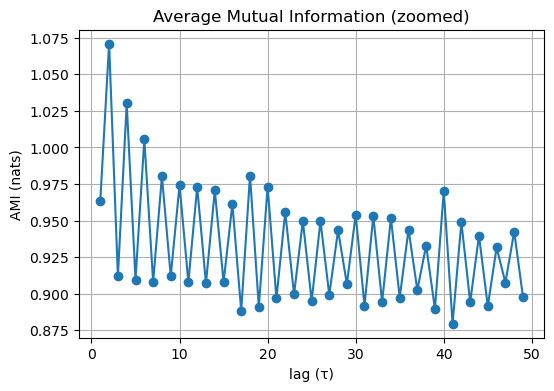

In [19]:

lags, ami = ami_curve(series, MAX_LAG, bins_spec=BINS)
tau = first_local_minimum(ami)
tau_method = 'AMI first local minimum'
if tau is None:
    t_acf = delay_from_acf(series, MAX_LAG)
    if t_acf is not None:
        tau = t_acf
        tau_method = 'ACF <= 1/e fallback'
    else:
        tau = 1
        tau_method = 'fallback tau=1'

print(f'Selected tau = {tau} ({tau_method})')

plt.figure(figsize=(6,4))
plt.plot(lags[1:50], ami[1:50], marker='o')
plt.xlabel('lag (τ)')
plt.ylabel('AMI (nats)')
plt.title('Average Mutual Information (zoomed)')
plt.grid(True)
plt.show()


Selected m = 18 (fallback argmin |E1-1|)


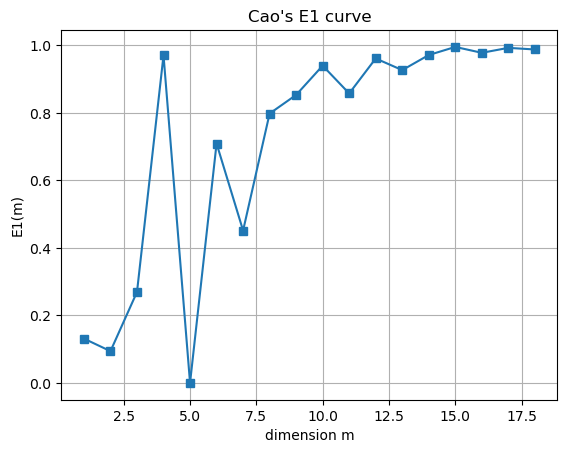

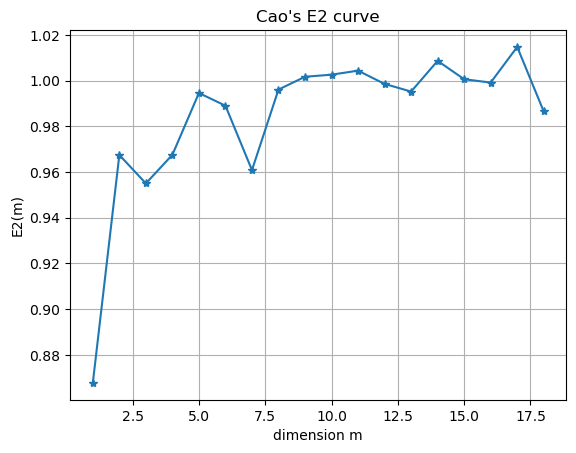

In [22]:
E1, E2 = cao_e1e2(series, MAX_DIM, tau)
m_sel = choose_m_from_E1(E1[:, 1], eps=PLATEAU_TOL, hold_for=PLATEAU_RUN)
m_method = f"plateau |ΔE1|<{PLATEAU_TOL} for {PLATEAU_RUN} steps" if m_sel is not None else "fallback argmin |E1-1|"
if m_sel is None:
    m_sel = 1 + int(np.argmin(np.abs(E1[1:, 1] - 1)))  # after m>=2

print(f"Selected m = {m_sel} ({m_method})")

# Plot E1 and E2 (one figure per chart)
plt.figure()
plt.plot(E1[:, 0], E1[:, 1], marker='s')
plt.xlabel('dimension m')
plt.ylabel('E1(m)')
plt.title("Cao's E1 curve")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(E2[:, 0], E2[:, 1], marker='*')
plt.xlabel('dimension m')
plt.ylabel('E2(m)')
plt.title("Cao's E2 curve")
plt.grid(True)
plt.show()




In [15]:

# Reconstruct
X = reconstruct(series, m_sel, tau)  # shape (m, M)
M = X.shape[1]
print(f'Embedded matrix X shape: {X.shape} (usable points M={M})')

lambda1 = np.nan
if DO_WOLF:
    P = (2 * tau) if THEILER is None else int(THEILER)
    try:
        lambda1 = lyapunov_wolf(series, m_sel, tau, P)
        print(f'Estimated largest Lyapunov exponent (Wolf): {lambda1:.4f} nat/sample  [Theiler P={P}]')
    except Exception as e:
        print(f'Wolf method failed: {e}')

# Save embedded trajectories to CSV
out_path = '/mnt/data/embedded_trajectories.csv'
np.savetxt(out_path, X.T, delimiter=',')
print(f'Saved embedded trajectories to: {out_path}')


NameError: name 'm_sel' is not defined


## Summary
- **τ (delay)** is chosen via the first local minimum of AMI, with an ACF 1/e fallback.
- **m (dimension)** is chosen where **E1** plateaus (small successive differences), with a fallback to the closest value to 1.
- **λ₁ (Wolf)** is optional and illustrative. For research-grade estimation, consider cross-checking with other methods (e.g., Rosenstein, Kantz).
- Embedded trajectories have been saved to `/mnt/data/embedded_trajectories.csv`.
